In [2]:
import os

import cosima_cookbook as cc
from dask.distributed import Client

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cmocean as cmo

In [3]:
fs_small = 18
fs_large = 24
plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('axes', labelsize=fs_large)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
plt.rc('text', usetex=False)

In [4]:
outdir = os.path.join(os.sep, 'g', 'data', 'v45', 'jm6603', 'checkouts', 'phd', 'src', 'cosima', '02_manuscript', 'output')

In [5]:
# location limits of dataset
lon_lim = slice(-226, -211.5)
lat_lim = slice(-53, -47.8)
# lon_lim = slice(-225, -211)
# lat_lim = slice(-53.5, -46.5)

meander_period = slice('1997-02-15', '1997-05-31')
flex_period = slice('1997-04-10', '1997-04-25')
monthly_period = slice('1997-04-01', '1997-04-30')
mid_month = '1997-04-16'

period = {'meander_period': meander_period, 
          'flex_period': flex_period,
          'monthly_period': monthly_period, 
          'mid_month': mid_month}
time_period = 'flex_period'

In [6]:
### load datasets

In [7]:
coordinates = xr.open_dataset(os.path.join(outdir, 'coordinates.nc'))
coordinates_plot = coordinates.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
coordinates_plot = coordinates_plot.assign_coords(
    {'xt_ocean':((coordinates_plot.xt_ocean + 180) % 360) - 180, 'xu_ocean':((coordinates_plot.xu_ocean + 180) % 360) - 180})

hydro = xr.open_dataset(os.path.join(outdir, 'hydro.nc'))
hydro_plot = hydro.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
hydro_plot = hydro_plot.assign_coords(
    {'xt_ocean':((hydro_plot.xt_ocean + 180) % 360) - 180, 'xu_ocean':((hydro_plot.xu_ocean + 180) % 360) - 180})

geos_vel = xr.open_dataset(os.path.join(outdir, 'geos-vel.nc'))
geos_vel_plot = geos_vel.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
geos_vel_plot = geos_vel_plot.assign_coords(
    {'xt_ocean':((geos_vel_plot.xt_ocean + 180) % 360) - 180, 'xu_ocean':((geos_vel_plot.xu_ocean + 180) % 360) - 180})

In [8]:
geos_vel_plot = xr.merge([coordinates_plot.kmu, coordinates_plot.kmt, geos_vel_plot])
kmu = (geos_vel_plot['kmu'].astype(int) - 3).load()

## Constants

In [9]:
# g = 9.81
# rho_0 = 1036 # kg/m^3
p_ref = 0 #1500
p_mld = 200
p_int = 2500

In [10]:
core_contour = -0.4
sl_contours = np.linspace(-0.4, 0.4, 5) + core_contour #[core_contour-0.2, core_contour, core_contour+0.2]
p_contours = [-0.18, -0.12, -0.06, 0.06, 0.12, 0.18]

## Pressure anomaly against long(er) term mean

In [11]:
p_baseline = hydro_plot.pressure.sel(time=meander_period).mean('time')
p_anomalous = (hydro_plot.pressure.sel(time=flex_period) - p_baseline).compute()

## Geostrophic and ageostrophic velocities at different depths

In [19]:
plt.rcParams.update(plt.rcParamsDefault)

In [20]:
plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm', 'font.size': fs_small})

Text(-0.02, 0.5, 'Latitude ($^oS$)')

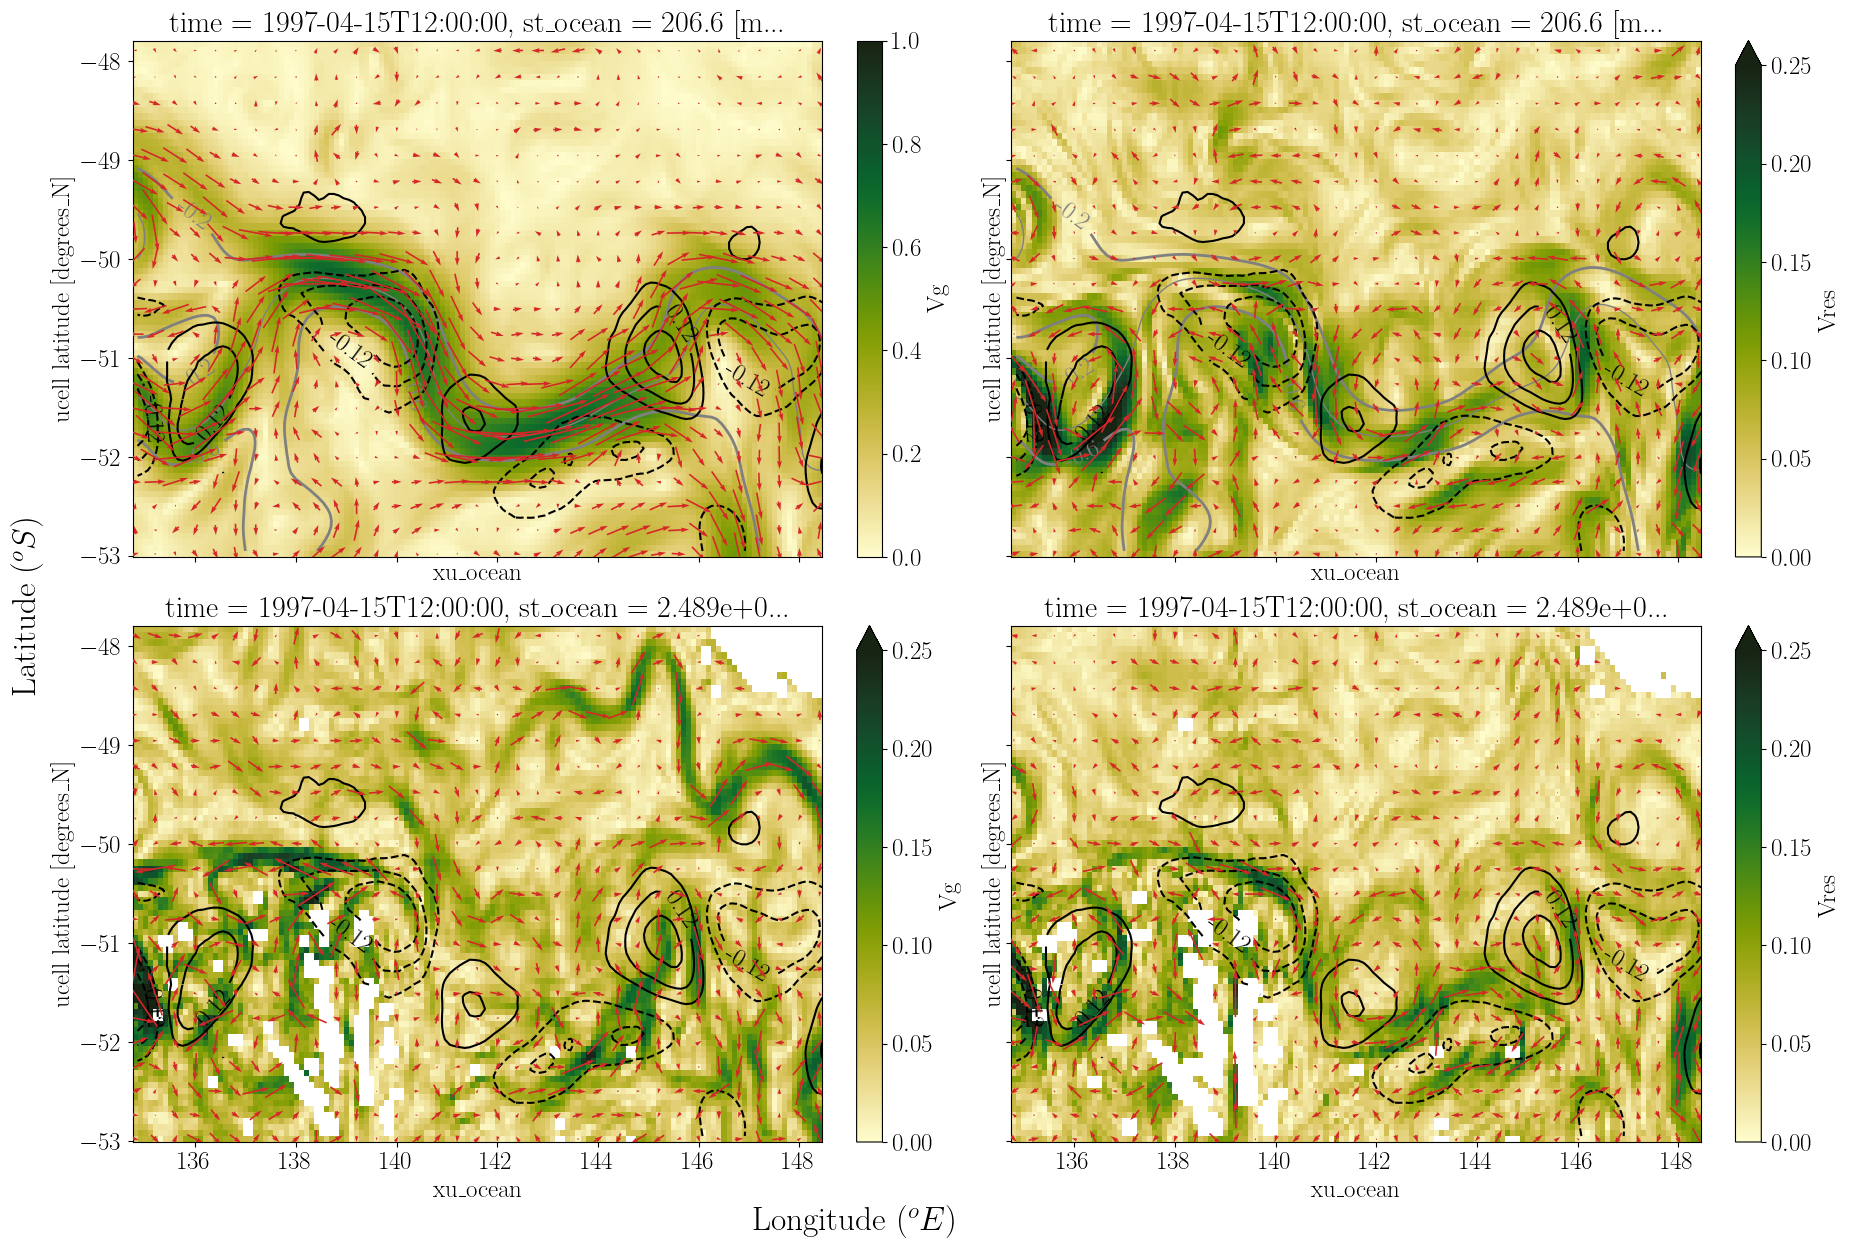

In [22]:
slc = slice(None, None, 3)
cmap = cmo.cm.speed
# cmap.
vmin, vmax = 0, 0.25
time_sel = '1997-04-15'

depths = {0: 200, 1: 2500}
nrows, ncols = 2, 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, nrows*6), constrained_layout=True, sharex=True, sharey=True)
for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    # if (r, c) != (0, 1):
    ax[r, c].set_xlabel('')
    ax[r, c].set_ylabel('')
    
    # plot sea level
    if depths[r] == 200:

        cont = geos_vel_plot.sea_level.sel(time=time_sel).isel(time=0).plot.contour(
            ax=ax[r, c], levels=sl_contours[1:-1], linestyles='solid', linewidths=1, colors='gray', add_labels=False)
        for ib, b in enumerate(sl_contours[1:-1]):
            if b in sl_contours[1:-1:2]:
                zc = cont.collections[ib]
                plt.setp(zc, linewidth=2)
        ax[r, c].clabel(cont, sl_contours[1:-1:2], inline=1, fontsize=fs_small, fmt='%.1f')

    # plot deep pressure anomalies
    pcont = p_anomalous.sel(st_ocean=p_int, method='nearest').sel(time=time_sel).isel(time=0).plot.contour(
        ax=ax[r, c], levels=p_contours, colors='k', zorder=9, add_labels=False)#cmap=plt.cm.RdGy)
    ax[r, c].clabel(pcont, p_contours[1::3], inline=1, fontsize=fs_small, fmt='%.2f')

    # plot geostrophic velocities
    vmax = 1 if (r, c) == (0, 0) else 0.25
    if c == 0:
        # if depths[r] == 'bottom':
        #     Vgb = geos_vel_plot.isel(st_ocean=kmu).sel(time=time_sel)
        #     Vgb.Vg.plot(ax=ax[r, c], cmap=cmap, vmin=vmin, vmax=vmax)
        #     coordinates.ht.plot.contour(ax=ax[r, c], levels=[2000,2500], colors=['k', (1, 1, 1, 0.4)], linewidths=.5)
        # else:
        geos_vel_plot.Vg.sel(st_ocean=depths[r], method='nearest').sel(time=time_sel).plot(ax=ax[r, c], cmap=cmap, vmin=vmin, vmax=vmax)
        if depths[r] != 200:
            coordinates.ht.plot.contour(ax=ax[r, c], levels=[2000, 2500], colors=['k', (1, 1, 1, 0.4)], linewidths=.5)
        
        # plot geostrophic velocities vectors
        scale = 1 if depths[r] == 200 else 0.5
        geos_vel_plot.sel(st_ocean=depths[r], method='nearest').sel(time=time_sel).isel(time=0).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
            ax=ax[r, c], x='xu_ocean', y='yu_ocean', u='ug', v='vg',
            units='inches', scale=scale, width=9e-4*fig.get_size_inches()[0], pivot='mid', add_guide=False, color='tab:red', zorder=11)
    
    # plot ageostrophic velocities
    if c == 1:
        # if depths[r] == 'bottom':
        #     geos_vel_plot.Vres.isel(st_ocean=kmu).sel(time=time_sel).plot(ax=ax[r, c], cmap=cmap, vmin=vmin, vmax=vmax)
        #     coordinates.ht.plot.contour(levels=[1500, 2000, 2500], colors=['k', (1, 1, 1, 0.4)], linewidths=.5)
        # else:
        geos_vel_plot.Vres.sel(st_ocean=depths[r], method='nearest').sel(time=time_sel).plot(ax=ax[r, c], cmap=cmap, vmin=vmin, vmax=vmax)
        if depths[r] != 200:
            coordinates.ht.plot.contour(ax=ax[r, c], levels=[1500, 2000, 2500], colors=['k', (1, 1, 1, 0.4)], linewidths=.5)

        # plot ageostrophic velocities vectors
        geos_vel_plot.sel(st_ocean=depths[r], method='nearest').sel(time=time_sel).isel(time=0).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
            ax=ax[r, c], x='xu_ocean', y='yu_ocean', u='ures', v='vres',
            units='inches', scale=0.5, width=9e-4*fig.get_size_inches()[0], pivot='mid', add_guide=False, color='tab:red', zorder=11)

fig.text(0.45, -0.02, r'Longitude ($^oE$)', ha='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Latitude ($^oS$)', va='center', rotation='vertical', fontsize=fs_large)

In [45]:
slc = slice(None, None, 3)

<a list of 5 text.Text objects>

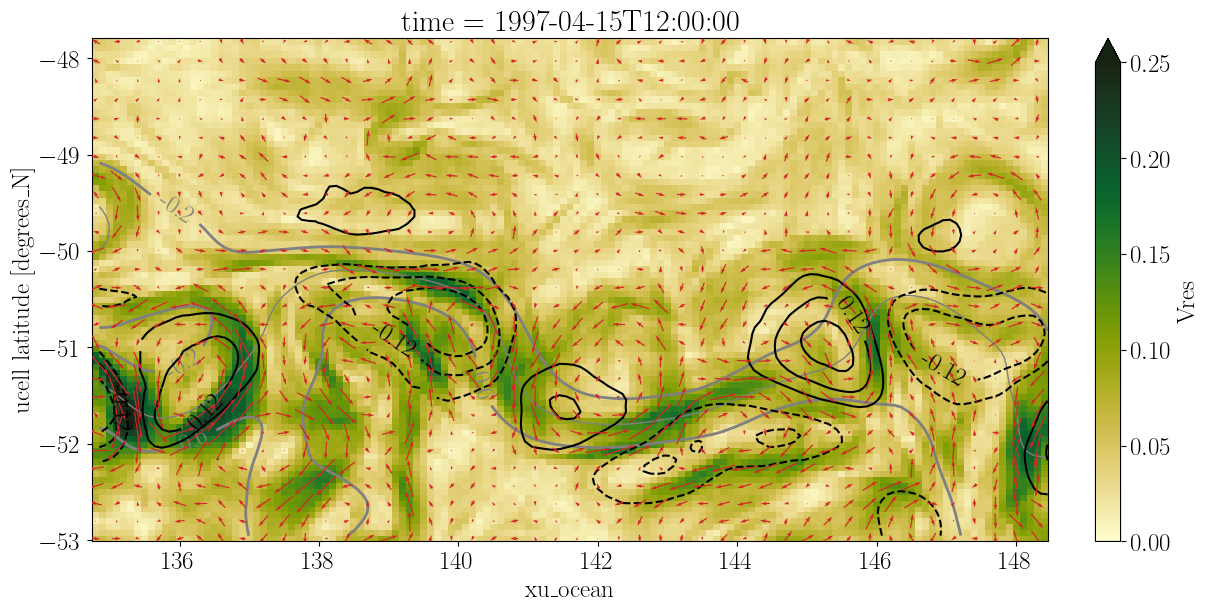

In [46]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)

geos_vel_plot.Vres.sel(time=time_sel).isel(st_ocean=slice(30,None)).mean('st_ocean').plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)

# plot sea level contours
cont = geos_vel_plot.sea_level.sel(time=time_sel).isel(time=0).plot.contour(
    ax=ax, levels=sl_contours[1:-1], linestyles='solid', linewidths=1, colors='gray', add_labels=False)
for ib, b in enumerate(sl_contours[1:-1]):
    if b in sl_contours[1:-1:2]:
        zc = cont.collections[ib]
        plt.setp(zc, linewidth=2)
ax.clabel(cont, sl_contours[1:-1:2], inline=1, fontsize=fs_small, fmt='%.1f')

# plot ageostrophic velocities vectors
geos_vel_plot.sel(time=time_sel).isel(time=0).isel(st_ocean=slice(30,None)).mean('st_ocean').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax, x='xu_ocean', y='yu_ocean', u='ures', v='vres',
    units='inches', scale=0.5, width=1e-3*fig.get_size_inches()[0], pivot='mid', add_guide=False, color='tab:red', zorder=11)

# plot deep pressure anomalies
pcont = p_anomalous.sel(st_ocean=p_int, method='nearest').sel(time=time_sel).isel(time=0).plot.contour(
    ax=ax, levels=p_contours, colors='k', zorder=9, add_labels=False)#cmap=plt.cm.RdGy)
ax.clabel(pcont, p_contours[1::3], inline=1, fontsize=fs_small, fmt='%.2f')

<a list of 4 text.Text objects>

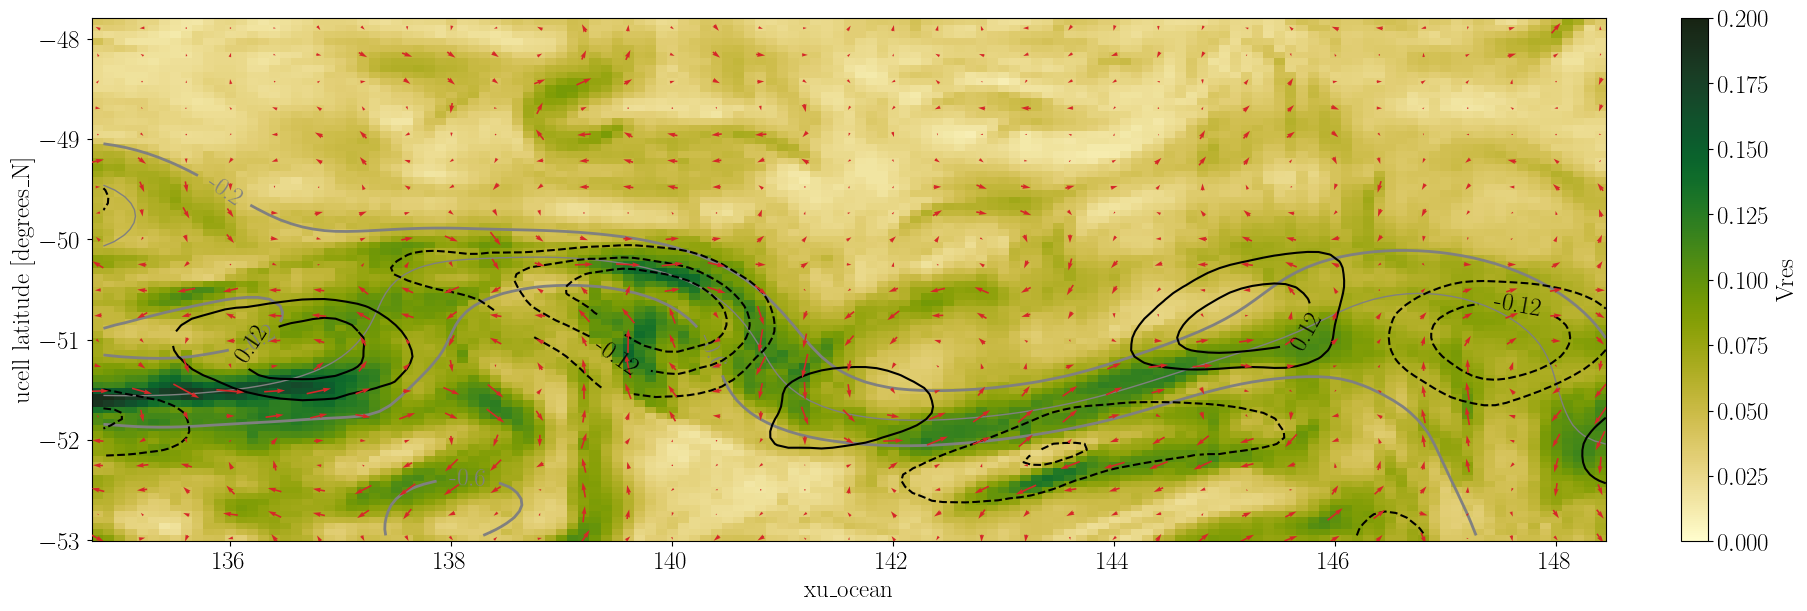

In [38]:
fig, ax = plt.subplots(figsize=(18, 6), constrained_layout=True, sharex=True, sharey=True)

geos_vel_plot.Vres.sel(time=period[time_period]).mean('time').isel(st_ocean=slice(30,None)).mean('st_ocean').plot(ax=ax, cmap=cmap, vmin=vmin, vmax=0.2)

# plot sea level contours
cont = geos_vel_plot.sea_level.sel(time=period[time_period]).mean('time').plot.contour(
    ax=ax, levels=sl_contours[1:-1], linestyles='solid', linewidths=1, colors='gray', add_labels=False)
for ib, b in enumerate(sl_contours[1:-1]):
    if b in sl_contours[1:-1:2]:
        zc = cont.collections[ib]
        plt.setp(zc, linewidth=2)
ax.clabel(cont, sl_contours[1:-1:2], inline=1, fontsize=fs_small, fmt='%.1f')

# plot ageostrophic velocities vectors
geos_vel_plot.sel(time=period[time_period]).mean('time').isel(st_ocean=slice(30,None)).mean('st_ocean').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax, x='xu_ocean', y='yu_ocean', u='ures', v='vres',
    units='inches', scale=0.5, width=9e-4*fig.get_size_inches()[0], pivot='mid', add_guide=False, color='tab:red', zorder=11)

# plot deep pressure anomalies
pcont = p_anomalous.sel(time=period[time_period]).mean('time').isel(st_ocean=p_int, method='nearest').plot.contour(
    ax=ax, levels=p_contours, colors='k', zorder=9, add_labels=False)#cmap=plt.cm.RdGy)
ax.clabel(pcont, p_contours[1::3], inline=1, fontsize=fs_small, fmt='%.2f')